# Simple SageMaker Sample: XGBoost Hyperparameter Tuning, Training & Deployment

## Contents

1. [Introduction](#Introduction)
2. [Preparation](#Preparation)
3. [Get the Data](#Download-and-prepare-the-data)
4. [Simple Model Training](#Perform-a-simple-training-job)
5. [Hyperparameter Optimization Model Training](#Hyper-parameter-tuning)
6. [Deploy Model](#Deploy-our-model)
7. [Local Deploy and Testing](#Local-deploy-and-testing)

## Introduction
This notebook walks through building a SageMaker model using the SageMaker Python APIs.  We are using Tensorflow as the framework that drives our training jobs.  The samples here have been copied and modified from the various examples and notebooks published by AWS on the AWS GitHub site.

## Preparation

In [1]:
# Install dependencies.
!pip install zipfile38

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [19]:
# Python Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
import sys
import math
import os
import zipfile
import sagemaker
from sagemaker.predictor import csv_serializer
import boto3
from sagemaker.tuner import (
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.tensorflow import TensorFlow
from sagemaker.image_uris import retrieve

# Define Session Variables
region = boto3.Session().region_name
sagemaker_client = boto3.Session().client("sagemaker")

role = sagemaker.get_execution_role()

# Set the S3 we will use for this, replace with the value you will use for this lab.
bucket = "S3-BUCKET-NAME"
prefix = "bank-additional"

# Request the algorithm image & version from this region
container = retrieve("xgboost", region, "latest")

## Download and Prepare the Data
In this section we will prepare our training, validation, and test data sets for our model.  There are several steps in this section that we will perform by hand using numpy and pandas.  However, all of these steps can be automated in [SageMaker Studio using DataWrangler](https://sagemaker-immersionday.workshop.aws/lab1/option1.html).  

The sections in the data preparation piece of this lab are as follows:
1. Download the data set
2. Perform preliminary analysis
3. Feature Engineering
4. Shuffle, Split & Store to S3

The example data set we are using is designed to predict if customers of a bank will enroll for a CD (certificate of deposit).  The data set has been sourced from the University of California, Irvine, and a version of the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

### Download the Data Set

In [78]:
!wget https://sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
    
with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

--2021-07-08 18:25:25--  https://sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com (sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com)... 52.219.101.58
Connecting to sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com (sagemaker-sample-data-us-east-2.s3-us-east-2.amazonaws.com)|52.219.101.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 422.68K  --.-KB/s    in 0.01s   

2021-07-08 18:25:25 (39.1 MB/s) - ‘bank-additional.zip’ saved [432828/432828]



In [79]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv')
pd.set_option('display.max_rows', 20)
data

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  pdays  previous  \
0      telephone   may         mon  ...         1    999         0   
1      telephone   may         mon  ...         1    999         0   
2      telephone   may         mon  ...         1    999         0   
3      telephone   may         mon  ...         1    999         0   
4      telephone   may         mon  ...         1    999         0   
...          ...   ...         ...  ...       ...    ...       ...   
41183   cellular   nov         fri  ...         1    999         0   
41184   cellular   nov         fri  ...         1    999         0   
41185   cellular   nov         fri  ...         2    999         0   
41186   cellular   nov         fri  ...         1    999         0   
41187   cellular   nov         fri  ...         3    999         1   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent          1.1          93.994          -36.4      4.857   
1      nonexistent          1.1          93.994          -36.4      4.857   
2      nonexistent          1.1          93.994          -36.4      4.857   
3      nonexistent          1.1          93.994          -36.4      4.857   
4      nonexistent          1.1          93.994          -36.4      4.857   
...            ...          ...             ...            ...        ...   
41183  nonexistent         -1.1          94.767          -50.8      1.028   
41184  nonexistent         -1.1          94.767          -50.8      1.028   
41185  nonexistent         -1.1          94.767          -50.8      1.028   
41186  nonexistent         -1.1          94.767          -50.8      1.028   
41187      failure         -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

### Perform Preliminary Analysis

Here we will plot observations from our dataset.  The goal here is to understand how our dataset looks and what features correlate to each other.

col_0          % observations
job                          
admin.               0.253035
blue-collar          0.224677
entrepreneur         0.035350
housemaid            0.025736
management           0.070992
retired              0.041760
self-employed        0.034500
services             0.096363
student              0.021244
technician           0.163713
unemployed           0.024619
unknown              0.008012

col_0     % observations
marital                 
divorced        0.111974
married         0.605225
single          0.280859
unknown         0.001942

col_0                % observations
education                          
basic.4y                   0.101389
basic.6y                   0.055647
basic.9y                   0.146766
high.school                0.231014
illiterate                 0.000437
professional.course        0.127294
university.degree          0.295426
unknown                    0.042027

col_0    % observations
default                
no             0.791201
unknown        0.208726
yes            0.000073

col_0    % observations
housing                
no             0.452122
unknown        0.024036
yes            0.523842

col_0    % observations
loan                   
no             0.824269
unknown        0.024036
yes            0.151695

col_0      % observations
contact                  
cellular         0.634748
telephone        0.365252

col_0  % observations
month                
apr          0.063902
aug          0.149995
dec          0.004419
jul          0.174177
jun          0.129115
mar          0.013256
may          0.334296
nov          0.099568
oct          0.017432
sep          0.013839

col_0        % observations
day_of_week                
fri                0.190031
mon                0.206711
thu                0.209357
tue                0.196416
wed                0.197485

col_0        % observations
poutcome                   
failure            0.103234
nonexistent        0.863431
success            0.033335

col_0  % observations
y                    
no           0.887346
yes          0.112654

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

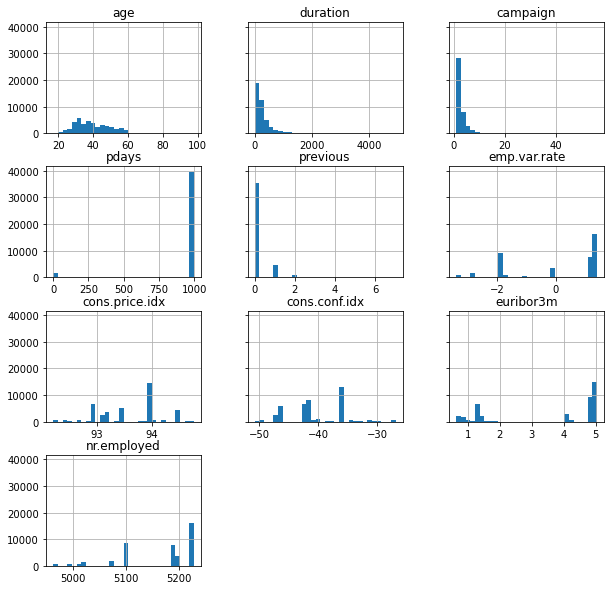

In [80]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))
    
# Histograms for each numeric feature
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10,10))

y                    no       yes
job                              
admin.         0.248167  0.291379
blue-collar    0.235745  0.137500
entrepreneur   0.036445  0.026724
housemaid      0.026103  0.022845
management     0.071030  0.070690
retired        0.035187  0.093534
self-employed  0.034804  0.032112
services       0.099759  0.069612
student        0.016417  0.059267
technician     0.164523  0.157328
unemployed     0.023804  0.031034
unknown        0.008017  0.007974

y               no       yes
marital                     
divorced  0.113166  0.102586
married   0.612783  0.545690
single    0.272190  0.349138
unknown   0.001861  0.002586

y                          no       yes
education                              
basic.4y             0.102550  0.092241
basic.6y             0.057568  0.040517
basic.9y             0.152457  0.101940
high.school          0.232133  0.222198
illiterate           0.000383  0.000862
professional.course  0.127175  0.128233
university.degree    0.287239  0.359914
unknown              0.040495  0.054095

y              no       yes
default                    
no       0.776814  0.904526
unknown  0.223104  0.095474
yes      0.000082  0.000000

y              no       yes
housing                    
no       0.454088  0.436638
unknown  0.024160  0.023060
yes      0.521752  0.540302

y              no       yes
loan                       
no       0.823574  0.829741
unknown  0.024160  0.023060
yes      0.152266  0.147198

y               no       yes
contact                     
cellular   0.60991  0.830388
telephone  0.39009  0.169612

y            no       yes
month                    
apr    0.057267  0.116164
aug    0.151116  0.141164
dec    0.002545  0.019181
jul    0.178532  0.139871
jun    0.130212  0.120474
mar    0.007388  0.059483
may    0.352495  0.190948
nov    0.100826  0.089655
oct    0.011027  0.067888
sep    0.008591  0.055172

y                  no       yes
day_of_week                    
fri          0.191009  0.182328
mon          0.209779  0.182543
thu          0.207344  0.225216
tue          0.195277  0.205388
wed          0.196591  0.204526

y                  no       yes
poutcome                       
failure      0.099787  0.130388
nonexistent  0.887107  0.676940
success      0.013106  0.192672

age


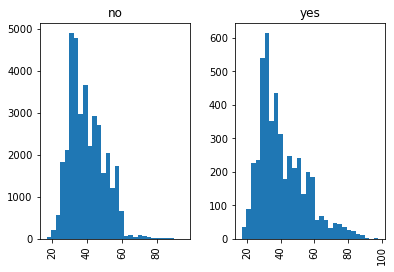

duration


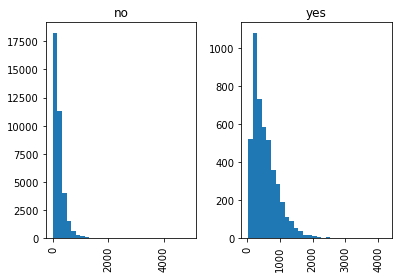

campaign


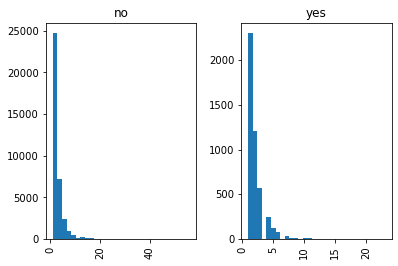

pdays


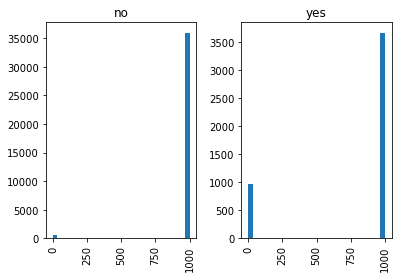

previous


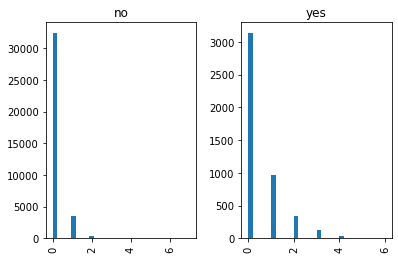

emp.var.rate


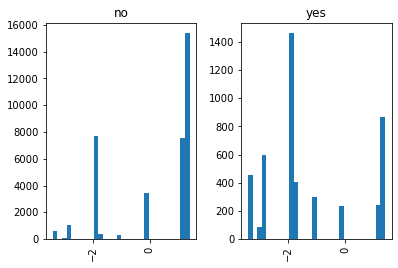

cons.price.idx


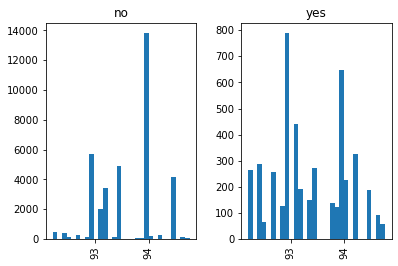

cons.conf.idx


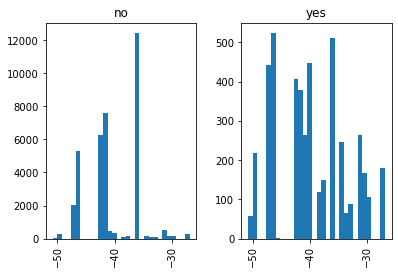

euribor3m


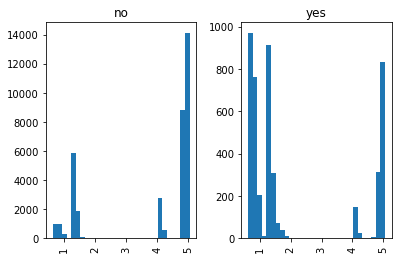

nr.employed


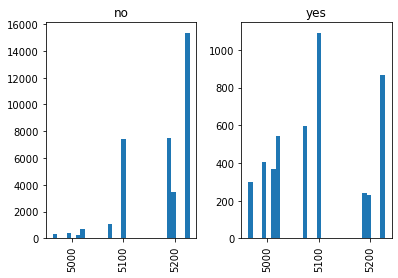

In [81]:
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))
        
for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754        0.127836      -0.013733   0.135133   
pdays               0.271004        0.078889      -0.091342   0.296899   
previous           -0.420489       -0.203130      -0.050936  -0.454494   
emp.var.rate        1.000000        0.775334       0.196041   0.972245   
cons.price.idx      0.775334        1.000000       0.058986   0.688230   
cons.conf.idx       0.196041        0.058986       1.000000   0.277686   
euribor3m           0.972245        0.688230       0.277686   1.000000   
nr.employed         0.906970        0.522034       0.100513   0.945154   

                nr.employed  
age               -0.017725  
duration          -0.044703  
campaign           0.144095  
pdays              0.372605  
previous          -0.501333  
emp.var.rate       0.906970  
cons.price.idx     0.522034  
cons.conf.idx      0.100513  
euribor3m          0.945154  
nr.employed        1.000000

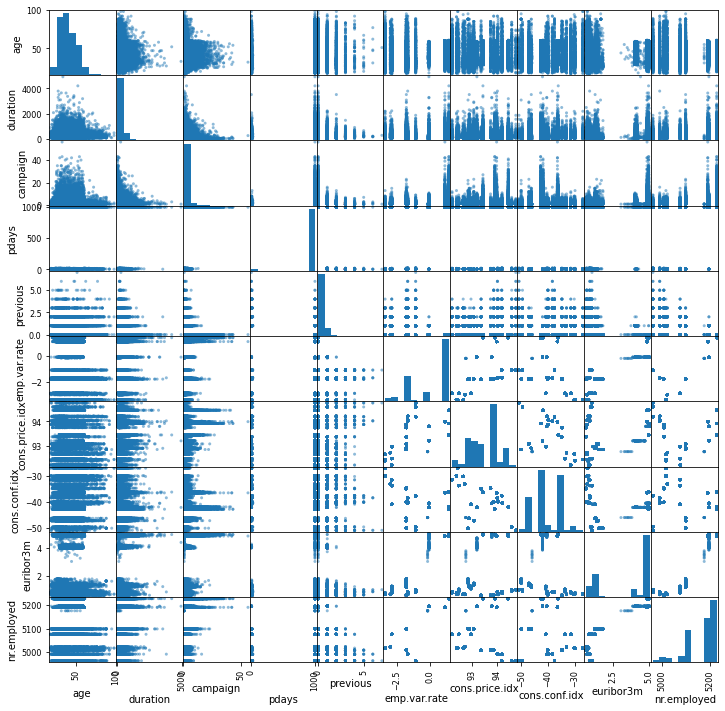

In [8]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12,12))
plt.show()

### Feature Engineering
Here we perform some feature engineering.  First, we define a column that describes if a customer has been contacted once before.  Then, we conflate employment information to describe if a person is working or not.  Then we perform One-Hot Encoding on our categorical features.  Finally, we drop a few columns that we have already discerned are inconsequential to column `y`.

In [82]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)
model_data = pd.get_dummies(data)

In [83]:
model_data

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0       56       261         1    999         0           1.1          93.994   
1       57       149         1    999         0           1.1          93.994   
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
4       56       307         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41183   73       334         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
41185   56       189         2    999         0          -1.1          94.767   
41186   44       442         1    999         0          -1.1          94.767   
41187   74       239         3    999         1          -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  ...  day_of_week_fri  \
0              -36.4      4.857       5191.0  ...                0   
1              -36.4      4.857       5191.0  ...                0   
2              -36.4      4.857       5191.0  ...                0   
3              -36.4      4.857       5191.0  ...                0   
4              -36.4      4.857       5191.0  ...                0   
...              ...        ...          ...  ...              ...   
41183          -50.8      1.028       4963.6  ...                1   
41184          -50.8      1.028       4963.6  ...                1   
41185          -50.8      1.028       4963.6  ...                1   
41186          -50.8      1.028       4963.6  ...                1   
41187          -50.8      1.028       4963.6  ...                1   

       day_of_week_mon  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
0                    1                0                0                0   
1                    1                0                0                0   
2                    1                0                0                0   
3                    1                0                0                0   
4                    1                0                0                0   
...                ...              ...              ...              ...   
41183                0                0                0                0   
41184                0                0                0                0   
41185                0                0                0                0   
41186                0                0                0                0   
41187                0                0                0                0   

       poutcome_failure  poutcome_nonexistent  poutcome_success  y_no  y_yes  
0                     0                     1                 0     1      0  
1                     0                     1                 0     1      0  
2                     0                     1                 0     1      0  
3                     0                     1                 0     1      0  
4                     0                     1                 0     1      0  
...                 ...                   ...               ...   ...    ...  
41183                 0                     1                 0     0      1  
41184                 0                     1                 0     1      0  
41185                 0                     1                 0     1      0  
41186                 0                     1                 0     0      1  
41187                 1                     0                 0     1      0  

[41188 rows x 67 columns]

In [84]:
model_data = model_data.drop(columns=['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

In [85]:
model_data

age  campaign  pdays  previous  no_previous_contact  not_working  \
0       56         1    999         0                    1            0   
1       57         1    999         0                    1            0   
2       37         1    999         0                    1            0   
3       40         1    999         0                    1            0   
4       56         1    999         0                    1            0   
...    ...       ...    ...       ...                  ...          ...   
41183   73         1    999         0                    1            1   
41184   46         1    999         0                    1            0   
41185   56         2    999         0                    1            1   
41186   44         1    999         0                    1            0   
41187   74         3    999         1                    1            1   

       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  ...  \
0               0                0                 0              1  ...   
1               0                0                 0              0  ...   
2               0                0                 0              0  ...   
3               1                0                 0              0  ...   
4               0                0                 0              0  ...   
...           ...              ...               ...            ...  ...   
41183           0                0                 0              0  ...   
41184           0                1                 0              0  ...   
41185           0                0                 0              0  ...   
41186           0                0                 0              0  ...   
41187           0                0                 0              0  ...   

       day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0                    0                1                0                0   
1                    0                1                0                0   
2                    0                1                0                0   
3                    0                1                0                0   
4                    0                1                0                0   
...                ...              ...              ...              ...   
41183                1                0                0                0   
41184                1                0                0                0   
41185                1                0                0                0   
41186                1                0                0                0   
41187                1                0                0                0   

       day_of_week_wed  poutcome_failure  poutcome_nonexistent  \
0                    0                 0                     1   
1                    0                 0                     1   
2                    0                 0                     1   
3                    0                 0                     1   
4                    0                 0                     1   
...                ...               ...                   ...   
41183                0                 0                     1   
41184                0                 0                     1   
41185                0                 0                     1   
41186                0                 0                     1   
41187                0                 1                     0   

       poutcome_success  y_no  y_yes  
0                     0     1      0  
1                     0     1      0  
2                     0     1      0  
3                     0     1      0  
4                     0     1      0  
...                 ...   ...    ...  
41183                 0     0      1  
41184                 0     1      0  
41185                 0     1      0  
41186                 0     0      1  
41187                 0     1      0  

[41188

### Shuffle, Split, Store in S3
This is a straightforward process of partitioning our dataset to be used to train, validate, and test our model.

In [86]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

print("Training Data Length ==> " + str(len(train_data.columns)))
print("Validation Data Length ==> " + str(len(validation_data.columns)))
print("Test Data Length ==> " + str(len(test_data.columns)))

Training Data Length ==> 61
Validation Data Length ==> 61
Test Data Length ==> 61


In [89]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [90]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

## Perform a Simple Training Job

In this section we'll discuss the various methods of training models in SageMaker.  We are using XGBoost as the avatar for this discussion.  There are several ways to train models in SageMaker; refer to the following outline for guidance.

https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#xgboost-modes
1. Framework Mode vs. Script Mode
2. Train XGBoost in Framework Mode
3. Train XGBoost in Script Mode
4. Train XGBoost as your own container
5. Additional Considerations for Training XGBoost
    a. [Training with Spot Instances](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_managed_spot_training.html)
    b. Distributed Training
    c. [SageMaker Debugger](https://sagemaker-examples.readthedocs.io/en/latest/aws_sagemaker_studio/sagemaker_studio_image_build/xgboost_bring_your_own/Batch_Transform_BYO_XGB.html)
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#xgboost-modes

In [17]:
# https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_managed_spot_training.html
# https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-python-sdk/tensorflow_moving_from_framework_mode_to_script_mode/tensorflow_moving_from_framework_mode_to_script_mode.html
# There's a conversation around training in framework vs. script mode.
# Additionally there's a conversation around migrating from framework to script mode.

# If possible let's stick to framework mode entirely.
# https://sagemaker.readthedocs.io/en/stable/frameworks/xgboost/using_xgboost.html#host-multiple-models-with-multi-model-endpoints

hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "binary:logistic",
    "num_round": "50",
    "verbosity": "2",
}

instance_type = "ml.m5.2xlarge"
output_path = "s3://{}/{}/output".format(bucket, prefix)
content_type = "csv"

import time
from sagemaker.inputs import TrainingInput

job_name = "DEMO-xgboost-spot-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Training job", job_name)

use_spot_instances = True
max_run = 3600
max_wait = 3600 if use_spot_instances else None
checkpoint_s3_uri = (
    "s3://{}/{}/checkpoints/{}".format(bucket, prefix, job_name) if use_spot_instances else None
)
print("Checkpoint path:", checkpoint_s3_uri)

xgb_model = sagemaker.estimator.Estimator(
    container,
    role,
    hyperparameters=hyperparameters,
    instance_count=1,
#     instance_count=4,
    instance_type=instance_type,
    volume_size=5,  # 5 GB
    output_path=output_path,
    sagemaker_session=sagemaker.Session(),
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
    checkpoint_s3_uri=checkpoint_s3_uri,
)
train_input = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "train/train.csv"), content_type=content_type
)
validation_input = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "validation/validation.csv"), content_type=content_type
)
xgb_model.fit({"train": train_input, "validation": validation_input}, job_name=job_name)
xgb_model.model_data

Training job DEMO-xgboost-spot-2021-07-08-17-32-15
Checkpoint path: s3://sagemaker-studio-329542461890-mzhlc3qf6r/bank-additional/checkpoints/DEMO-xgboost-spot-2021-07-08-17-32-15
2021-07-08 17:32:16 Starting - Starting the training job...
2021-07-08 17:32:39 Starting - Launching requested ML instancesProfilerReport-1625765535: InProgress
...
2021-07-08 17:33:07 Starting - Preparing the instances for training.........
2021-07-08 17:34:40 Downloading - Downloading input data
2021-07-08 17:34:40 Training - Downloading the training image.Arguments: train
[2021-07-08:17:34:50:INFO] Running standalone xgboost training.
[2021-07-08:17:34:50:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 23806.38mb
[2021-07-08:17:34:50:INFO] Determined delimiter of CSV input is ','
[17:34:50] S3DistributionType set as FullyReplicated
[17:34:50] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-07-

's3://sagemaker-studio-329542461890-mzhlc3qf6r/bank-additional/output/DEMO-xgboost-spot-2021-07-08-17-32-15/output/model.tar.gz'

## Hyper Parameter Tuning

Hyperparameter Tuning is a feature of Amazon SageMaker that allows customers to find the best hyperparameter values for their training jobs in the least amount of time.  This feature is available in the SageMaker UI within the AWS Console, the AWS CLI, and via the Python SageMaker API.  We will describe how to submit a HTJ (Hyperparameter Tuning Job) via API calls in this document.

The steps to submit an HTJ via the SageMaker Python API are as follows:
1. Decide which algorithm you want to tune.
2. Set initial weights on the hyperparameters for the selected algorithm.
3. Define the range of hyperparameters you want to tune against.
4. Define your hyperparameter tuning job.
5. Train your hyperparameter tuning job.
6. Evaluate the your results.

### Decide which algorithm to tune
Amazon SageMaker Hyperparameter Tuning allows you to tune built-in SageMaker algorithms as well as custom algorithms that you bring to the training environment.  To complete this process, you need to pull the model container using the `sagemaker.image_uris.retrieve` function call.  This function takes a model name, region and version number as parameters and returns a container object.

In [65]:
sagemaker_session = sagemaker.Session()

# Create a reference to an XGBoost model with the retrieved image
# The API call tells SageMaker what the algorithm is, what permissions it has, 
#   what kind and how many instances to train with, where output should do,
#   and the session credentials for this algorithms.
hyper_xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker_session,
)

### Set Initial Weights on Hyperparameters

Every algorithms has different hyperparameters.  Before you run a training job for hyperparameter tuning you need to set default weights on the algorithm for these hyperparameters.  During this phase we will also set the objective metric for the HTJ.

The objective metric is a metric used by Amazon SageMaker to compare the performance of hyperparameter tuning jobs against each other.  The model with the best performing metric is the model that should be used for training.

Every algorithm will have different hyperparameters.  It is important to understand what these hyperparameters are and they work at a high level before running an HTJ.  [XGBoost Hyperparameters & Objective Metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) are listed in the AWS Documentation for Amazon SageMaker.  

In [66]:
# Set the initial weights on XGBoost
hyper_xgb.set_hyperparameters(
    eval_metric="auc",
    objective="binary:logistic",
    num_round=10,
    rate_drop=0.3,
    tweedie_variance_power=1.4,
)

# Set the Objective Metric to compare job runs.
# This validation metric is Area Under the Curve.
objective_metric_name = "validation:auc"

### Define the range of Hyperparameters you want to Tune

Amazon SageMaker Hyperparameter Tuning Jobs require a specific range of values to use when testing hyperparameters.  You need to specify these ranges as `sagemaker.parameter.ParameterRange` objects in a dictionary.  This class is implemented in the `sagemaker.tuner` package with implementations for `IntegerParameter`, `CategoricalParameter` & `ContinuousParameter`.  In this example, we'll tune continuous parameters.

When specifying a parameter to tune, you pass a minimum value, a maximum value, and a scaling type.  Amazon SageMaker Hyperparameter Tuning Jobs support Linear and Logarithmic scaling for parameters.  Test both and see which perform best for you.

In [74]:
hyperparameter_ranges_logarithmic = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
}

hyperparameter_ranges_linear = {
    "alpha": ContinuousParameter(0.01, 10, scaling_type="Linear"),
    "lambda": ContinuousParameter(0.01, 10, scaling_type="Linear"),
}

### Define the Hyperparameter Tuning Job

A Hyperparameter Tuning Job is represented in the SageMaker API as a `HyperparameterTuner` object.  To create this object we must pass in many of the objects we've created up until this point.  We supply the algorithm we will tune, the objective metric, and the hyperparameter ranges.  Furthermore, we will set the number of jobs to run and the parallelization of these jobs.  

Finally, we must specify our tuning strategy.  Hyperparameter Tuning Jobs take a `Random` or `Bayesian` strategy, and we will showcase both in this example.

In [106]:
# Random Search Hyperparameter Tuning Job that scales Linearly.
random_linear_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Random",
)

# Random Search Hyperparameter Tuning Job that scales Logarithmically.
random_logarithmic_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_logarithmic,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Random",
)

# Bayesian Search Hyperparameter Tuning Job that scales Linearly.
bayesian_linear_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Bayesian",
)

# Bayesian Search Hyperparameter Tuning Job that scales Logarithmically.
bayesian_logarithmic_tuner_log = HyperparameterTuner(
    hyper_xgb,
    objective_metric_name,
    hyperparameter_ranges_logarithmic,
    max_jobs=10, max_parallel_jobs=4,
    strategy="Bayesian",
)

### Submit the Hyperparameter Tuning Job

The `fit(dict, bool)` method submits your Hyperparameter Tuning Job to Amazon SageMaker.  The hardware specified in the algorithm definition is initialized and the jobs are run in accordance with the instructions defined within the `HyperparameterTuner` job.

The hyperparameter ranges we've specified will be tested and modified across all of the jobs that run; these values will change based on the scaling strategy you utilize.

In [223]:
import string
import random

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "train/train.csv"), content_type=content_type
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "validation/validation.csv"), content_type=content_type
)
s3_input_test = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "test/test.csv"), content_type=content_type
)

letters = string.ascii_lowercase

In [110]:
suffix = ''.join(random.choice(letters) for i in range(10))
random_linear_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="random-linear-tuner-" + suffix
)

..................................................................................................................!


In [111]:
suffix = ''.join(random.choice(letters) for i in range(7))
random_logarithmic_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="random-logarithmic-tuner-" + suffix
)

................................................................................................................!


In [112]:
suffix = ''.join(random.choice(letters) for i in range(10))
bayesian_linear_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="bayesian-linear-tuner-" + suffix
)

..................................................................................................................!


In [113]:
suffix = ''.join(random.choice(letters) for i in range(5))
bayesian_logarithmic_tuner_log.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    include_cls_metadata=False,
    job_name="bayesian-logarithmic-tuner-" + suffix
)

..............................................................................................................!


### Evaluate the results

In this section we will use the Hyperparameter Tuning Job API to retrieve performance statistics for the 4 jobs we have built in this demo.  We start by checking if the jobs have completed.  Once completed, we get dataframes plotting the results of the Hyperparameter Tuning Jobs.  We supplement these jobs with meta data about the job run and then create a pandas dataframe.  Using third party libraries we plot these values out in a visualization.

In [115]:
client = boto3.client("sagemaker")

####################################
# Check if the jobs have completed #
####################################

random_linear_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=random_linear_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

random_logarithmic_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=random_logarithmic_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

bayesian_linear_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=bayesian_linear_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

bayesian_logarithmic_status_log = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=bayesian_logarithmic_tuner_log.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

In [146]:

########################################################################
# Gather the HyperparameterTuningJobAnalytics for each of jobs we ran. #
########################################################################

random_linear_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    random_linear_tuner_log.latest_tuning_job.job_name
).dataframe()
random_linear_df_log["strategy"] = "random|linear"

random_logarithmic_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    random_logarithmic_tuner_log.latest_tuning_job.job_name
).dataframe()
random_logarithmic_df_log["strategy"] = "random|logarithmic"

bayesian_linear_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    bayesian_linear_tuner_log.latest_tuning_job.job_name
).dataframe()
bayesian_linear_df_log["strategy"] = "bayesian|linear"

bayesian_logarithmic_df_log = sagemaker.HyperparameterTuningJobAnalytics(
    bayesian_logarithmic_tuner_log.latest_tuning_job.job_name
).dataframe()
bayesian_logarithmic_df_log["strategy"] = "bayesian|logarithmic"


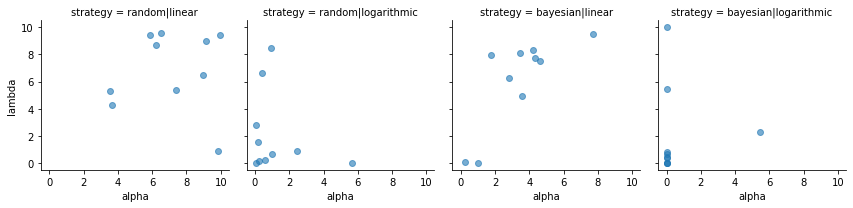

In [159]:

########################################################################
# Create the Pandas dataframe that plots the performance of our models #
########################################################################

# HOW DO LAMBDA AND ALPHA PLAY TOGETHER WITH XGBOOST?

# REMINDER: As Alpha and Lambda increase, the model becomes more conservative.
# Since we are using AUC as the objective metric, we can assume smaller values will be preferred.

df = pd.concat([
    random_linear_df_log,
    random_logarithmic_df_log,
    bayesian_linear_df_log,
    bayesian_logarithmic_df_log
], ignore_index=True)

g = sns.FacetGrid(df, col="strategy", palette="viridis")
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.6)

This concludes our segment on Hyperparameter Tuning.  The next task is to select the model we want to work with and deploy that model.

## Deploy Our Model
In this section we will discuss two seperate deployment paradigms.  We will deploy our model using a SageMaker hosted endpoint first, followed by a local deployment.  The steps for local deployment can be reused to deploy to a machine in a private or self-hosted environment.

In [ ]:
# Here we deploy the best of 1 of the 4 models...
from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer
hyper_predictor = random_linear_tuner_log.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer()
)

In [18]:
# Here we deploy the simple XGBoost model we trained earlier...
from sagemaker.deserializers import CSVDeserializer
from sagemaker.serializers import CSVSerializer
predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer()
)

-------------!

### Test our Deployed Model

In this section we'll utilize the testing data we created earlier on the model we deployed to a SageMaker endpoint.

Now, we’ll use a simple function to: 1. Loop over our test dataset 1. Split it into mini-batches of rows 1. Convert those mini-batchs to CSV string payloads 1. Retrieve mini-batch predictions by invoking the XGBoost endpoint 1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [74]:
predictor.predict("1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1")

[['0.17455749213695526']]

## Local Deploy and Testing
Here we will briefly summarize how to conduct the previous steps in a local environment.

In [48]:
!aws ecr get-login-password --region us-east-2 | docker login --username AWS --password-stdin 825641698319.dkr.ecr.us-east-2.amazonaws.com
!docker pull 825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest

trainedmodel = sagemaker.model.Model(
    model_data='s3://sagemaker-studio-329542461890-mzhlc3qf6r/bank-additional/output/DEMO-xgboost-spot-2021-07-08-17-32-15/output/model.tar.gz',
    image_uri=sagemaker.image_uris.retrieve(framework='xgboost',region='us-east-2',version='latest'),
    role=role)

trainedmodel.deploy(initial_instance_count=1, instance_type='local')


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Error response from daemon: pull access denied for 825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost, repository does not exist or may require 'docker login': denied: User: arn:aws:sts::329542461890:assumed-role/SageMakerStudioPipelineExecutionRole/SageMaker is not authorized to perform: ecr:BatchGetImage on resource: arn:aws:ecr:us-east-2:825641698319:repository/xgboost


CalledProcessError: Command '['docker', 'pull', '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest']' returned non-zero exit status 1.